# Zerotogans-project
The main objective of this project is developing a feedforward neural network to classify the natural scene. 
The target of this project is to build powerful neural network that can classify these images with more accuracy.
The input data is obtained from https://www.kaggle.com/puneet6060/intel-image-classification.

There are around 25k images of size 150*150 under 6 categories。 

In [ ]:
!pip install kaggle

mkdir is the command for creating a folder. %USERPROFILE is a system environment variable in Windows that points to the User’s 
Directory in C:\ drive.

In [ ]:
!mkdir %userprofile%\.kaggle

The second command just moves the file kaggle.json to the directory that you just created. But for this to work, you need to be in the directory where the file is present or specify the complete path to the file, otherwise it would not work. I would assume the file is downloaded to the Downloads folder for user so the command would be:

In [ ]:
!move %USERPROFILE%\Downloads\kaggle.json %USERPROFILE%\.kaggle

Check the file 'kaggle.json' is sucessfully moved to the directory .kaggle 

In [1]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.nn.functional as F

from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [2]:
# Project name used for jovian.commit
project_name = 'intel-image-classification'

In [3]:
dataset_url='https://www.kaggle.com/puneet6060/intel-image-classification/download'

In [4]:
import os
os.listdir('.kaggle')

['kaggle.json']

In [ ]:
#Import data files from Kaggle API
!kaggle datasets download -d puneet6060/intel-image-classification

The dataset is extracted to the directory data/intel-image-classification. It contains 2 folders train and test, containing the training set (50000 images) and test set (10000 images) respectively. Each of them contains 10 folders, one for each class of images. Let's verify this using os.listdir.

In [ ]:
import zipfile
with zipfile.ZipFile('./intel-image-classification.zip', 'r') as zip_ref:
    zip_ref.extractall('./intel-image-classification')

In [5]:
DATA_DIR = './intel-image-classification'

TRAIN_DIR = DATA_DIR + '/seg_train/seg_train'                           # Contains training images
TEST_DIR = DATA_DIR + '/seg_test/seg_test'                              # Contains test images 

In [6]:
print(os.listdir(DATA_DIR))

['seg_pred', 'seg_test', 'seg_train']


In [7]:
classes = os.listdir(DATA_DIR + "/seg_train/seg_train")
print(classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


Use the `ImageFolder` class from `torchvision` to load the data as PyTorch tensors.

In [8]:
from torchvision.datasets import ImageFolder
import torchvision.transforms as tt

In [9]:
stats = ((0.485, 0.456, 0.406),(0.229, 0.224, 0.225))

dataset_tf = tt.Compose([  tt.Resize((150,150)), 
                         tt.RandomHorizontalFlip(),
                         tt.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
                         tt.ToTensor(), 
                         tt.Normalize(*stats,inplace=True)])
#val_tf = tt.Compose([tt.Resize((150,150)),tt.ToTensor(), tt.Normalize(*stats)])

In [12]:
dataset = ImageFolder(DATA_DIR+'/seg_train/seg_train', transform=dataset_tf)

In [13]:
img, label = dataset[0]
print(img.shape, label)
img

torch.Size([3, 150, 150]) 0


tensor([[[ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         [ 2.2489,  2.2489,  2.2489,  ...,  2.2489,  2.2489,  2.2489],
         ...,
         [-0.4568, -1.3644, -1.2445,  ..., -1.2788, -1.0562, -1.3130],
         [-1.4672, -1.1760, -1.7754,  ..., -1.3987, -1.3130, -0.7822],
         [-1.0390, -1.2445, -1.6042,  ..., -1.0904, -1.1760, -1.1075]],

        [[ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         [ 2.4286,  2.4286,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
         ...,
         [-0.5301, -1.4230, -1.3179,  ..., -1.2129, -0.9853, -1.2654],
         [-1.5280, -1.2304, -1.8606,  ..., -1.3354, -1.2654, -0.7052],
         [-1.0903, -1.3179, -1.6856,  ..., -1.0203, -1.1078, -1.0378]],

        [[ 2.6400,  2.6400,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
         [ 2.6400,  2.6400,  2.6400,  ...,  2

In [14]:
print(dataset.classes)

['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [15]:
# Use the matpotlib to view the image 
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.facecolor'] = '#ffffff'

In [16]:
# to display an image and its label, permute: change the tensor dimension to (150,150,3)
def show_example(img, label):
    print('Label: ', dataset.classes[label], "("+str(label)+")")
    plt.imshow(img.permute(1, 2, 0))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Label:  buildings (0)


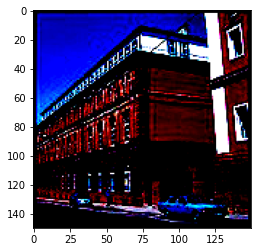

In [17]:
show_example(*dataset[1035])

In [18]:
import jovian

In [19]:
jovian.commit(project=project_name)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "pangzb-wm19/intel-image-classification" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Capturing environment..
[jovian] Committed successfully! https://jovian.ai/pangzb-wm19/intel-image-classification


'https://jovian.ai/pangzb-wm19/intel-image-classification'

## Training and Validation dataset
Since there's no predefined validation dataset, so a small portion of training dataset(10%) will be set aside to be used as validation set. 

In [20]:
random_seed = 12321
torch.manual_seed(random_seed)

In [21]:
val_size = int(0.1*len(dataset))
train_size = len(dataset) - val_size

train_ds, val_ds = random_split(dataset, [train_size, val_size])
len(train_ds), len(val_ds)

(12631, 1403)

In [22]:
jovian.log_dataset(dataset_url=dataset_url, val_size=val_size, random_seed=random_seed)

[jovian] Dataset logged.


In [23]:
batch_size=128
train_dl = DataLoader(train_ds,batch_size,shuffle = True, num_workers = 4, pin_memory = True)
valid_dl = DataLoader(val_ds, 200, num_workers = 4, pin_memory =True)

In [24]:
def show_batch(dl):
    for img, _ in dl:
        fig, ax = plt.subplots(figsize=(14, 14))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img[:64], nrow=8).permute(1, 2, 0))
        break

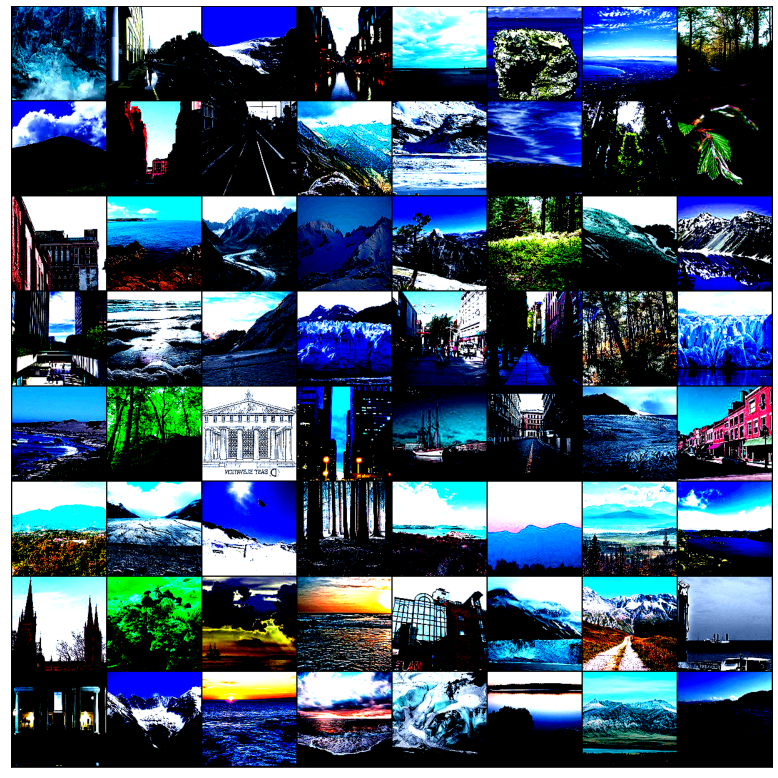

In [25]:
show_batch(train_dl)

In [26]:
# Commit the progress
jovian.commit(project=project_name, environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "pangzb-wm19/intel-image-classification" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/pangzb-wm19/intel-image-classification


'https://jovian.ai/pangzb-wm19/intel-image-classification'

## Using GPU to accelerate the training

In [27]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [28]:
device = get_default_device()
device

device(type='cpu')

In [30]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(valid_dl, device)

## Define the CNN model
In this projecte, we will use a convolutional neural network, using the nn.Conv2d class from PyTorch.

In [31]:
# Base Model for image classification
class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
        
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))


## Intel-image-classification module
In this model, we will use residual block fast foward the previous activation into a deeper layer in the nueral network.

In [32]:
def conv_block(inc,outc,pool = False):
    block = [
        nn.Conv2d(inc,outc,kernel_size=3, padding =1),
        nn.BatchNorm2d(outc),
        nn.ReLU(inplace=True)]
    if pool:
        block.append(nn.MaxPool2d(2))
    return nn.Sequential(*block)

In [33]:
class ResNet(ImageClassificationBase):
    def __init__(self,inc,nc):
        super().__init__()
        self.conv1 = conv_block(inc, 16)
        self.conv2 = conv_block(16, 32, pool = True)
        self.res1 = nn.Sequential(conv_block(32,32),conv_block(32,32))
        
        self.conv3 = conv_block(32,64,pool = True)
        self.conv4 = conv_block(64,128,pool = True)
        self.res2 = nn.Sequential(conv_block(128,128),conv_block(128,128))
        
        self.conv5 = conv_block(128,256,pool = True)
        self.conv6 = conv_block(256,512,pool = True)
        self.res3 = nn.Sequential(conv_block(512,512),conv_block(512,512))
        
        self.classifier = nn.Sequential(nn.MaxPool2d(4), 
                                        nn.Flatten(), 
                                        nn.Linear(512, nc))
        
    def forward(self, ip):
        out = self.conv1(ip)
        out = self.conv2(out)
        out = self.res1(out)+out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out)+out
        out = self.conv5(out)
        out = self.conv6(out)
        out = self.res3(out)+out
        out = self.classifier(out)
        return out

Convolution blocks here are pretty simple, we just return a **convolution layer**, a **normalisation layer** and our **activation layer(ReLU)**, and depending on the optional parameter pool we return a MaxPooling layer.

In [34]:
model= to_device(ResNet(3,6),torch.device("cpu"))
model

ResNet(
  (conv1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )

In [35]:
def try_batch(dl):
    
    for images, labels in dl:
        
        print('images.shape:', images.shape)
        out = model(images)
        print('out.shape:', out.shape)
        print('out[0]:', out[41])
        break

try_batch(train_dl)

images.shape: torch.Size([128, 3, 150, 150])
out.shape: torch.Size([128, 6])
out[0]: tensor([ 0.3668,  2.0393,  2.1889, -1.8419,  0.8041, -1.4082],
       grad_fn=<SelectBackward>)


## Training the model

In [36]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
    
    # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            #if grad_clip: 
             #   nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [37]:
history = [evaluate(model, val_dl)]
history

[{'val_loss': 1.7942664623260498, 'val_acc': 0.13249999284744263}]

In [38]:
epochs = 5
lr = 1e-3
grad_clip = 1e-1
weight_decay = 1e-5
optim_func = torch.optim.AdamW

In [39]:
history+=fit_one_cycle(epochs,lr,model,train_dl,val_dl, weight_decay = 1e-5,grad_clip = grad_clip, opt_func = optim_func)

Epoch [0], train_loss: 0.8987, val_loss: 1.1630, val_acc: 0.5960
Epoch [1], train_loss: 0.5391, val_loss: 0.7695, val_acc: 0.7621
Epoch [2], train_loss: 0.4001, val_loss: 0.4827, val_acc: 0.7735
Epoch [3], train_loss: 0.2953, val_loss: 0.3960, val_acc: 0.8446
Epoch [4], train_loss: 0.2210, val_loss: 0.3295, val_acc: 0.8552


Use GPU to accelerate the training, since 1 epoch requires 1hour, so the parameters no change.

In [42]:
jovian.reset()
jovian.log_hyperparams({
    'num_epochs': epochs,
    'opt_func': optim_func.__name__,
    'batch_size': batch_size,
    'lr': lr,
})

[jovian] Hyperparams logged.


In [43]:
jovian.log_metrics(train_loss=history[-1]['train_loss'], 
                   val_loss=history[-1]['val_loss'], 
                   val_acc=history[-1]['val_acc'])

[jovian] Metrics logged.


## Plotting Losses and Accuracy

In [44]:
def plot_losses(history):
    losses = [x["val_loss"] for x in history]
    plt.plot(losses,"-x")
    plt.xlabel("epoch")
    plt.ylabel("loss")
    plt.title("loss vs epochs")
    
def plot_acc(history):
    accs = [x["val_acc"] for x in history]
    plt.plot(accs,"-x")
    plt.xlabel("epoch")
    plt .ylabel("accuracy")
    plt.title("accuracy vs epochs")

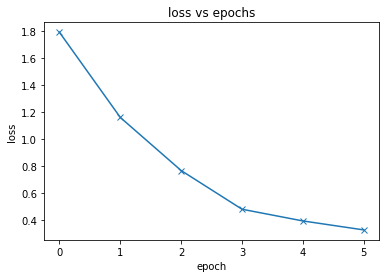

In [45]:
plot_losses(history)

## Testing the model using test dataset

In [46]:
def pred_single(img,model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim = 1)
    return preds[0].item()
    

In [48]:
test_ds = ImageFolder(DATA_DIR+'/seg_test/seg_test', transform=dataset_tf)

In [49]:
img, _ = test_ds[0]

'buildings'

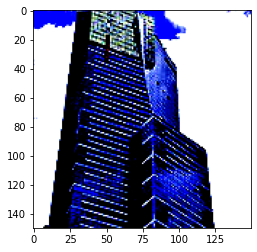

In [50]:
plt.imshow(img.permute(1,2,0))
pred = pred_single(img, model)
classes[pred]

prediction:	 buildings


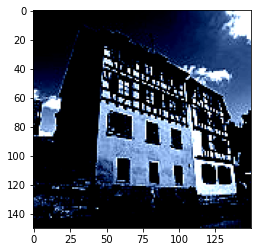

In [51]:
img, _ = test_ds[35]
pred = pred_single(img, model)
print("prediction:\t",classes[pred])
plt.imshow(img.permute(1,2,0))

prediction:	 buildings


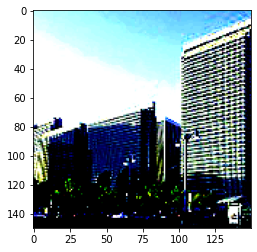

In [52]:
img , _ = test_ds[80]
pred = pred_single(img,model)
print("prediction:\t",classes[pred])
plt.imshow(img.permute(1,2,0))

prediction:	 glacier


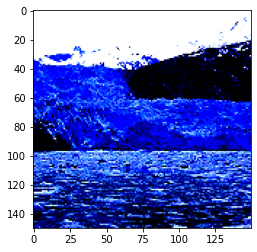

In [53]:
img, _ = test_ds[1314]
pred = pred_single(img, model)
print("prediction:\t",classes[pred])
plt.imshow(img.permute(1,2,0))

prediction:	 glacier


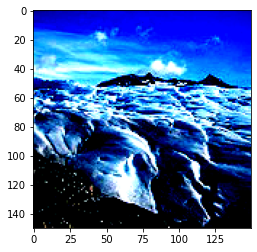

In [54]:
img, _ = test_ds[1035]
pred = pred_single(img, model)
print("prediction:\t",classes[pred])
plt.imshow(img.permute(1,2,0))

prediction:	 buildings


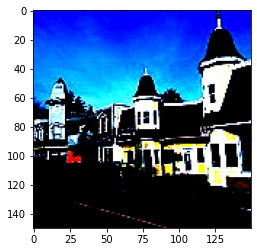

In [55]:
img, _ = test_ds[207]
pred = pred_single(img, model)
print("prediction:\t",classes[pred])
plt.imshow(img.permute(1,2,0))

In [57]:
jovian.commit(project = project_name,environment=None)

<IPython.core.display.Javascript object>

[jovian] Attempting to save notebook..
[jovian] Updating notebook "pangzb-wm19/intel-image-classification" on https://jovian.ai/
[jovian] Uploading notebook..
[jovian] Attaching records (metrics, hyperparameters, dataset etc.)
[jovian] Committed successfully! https://jovian.ai/pangzb-wm19/intel-image-classification


'https://jovian.ai/pangzb-wm19/intel-image-classification'